# Probability, efficiency and $\Delta$R

In [1]:
import h5py
import awkward as ak
import vector
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import mplhep as hep
from matplotlib.colors import LogNorm
hep.style.use(hep.style.ROOT)
mpl.rcParams['figure.dpi'] = 50
vector.register_awkward()

INFO:SparkMonitorKernel:SparkMonitor comm opened from frontend.


In [2]:
df = h5py.File('./SPANet/0903_output_v5_matched.h5','r')
df_input = h5py.File('./SPANet/data/tth_matched_2.h5','r')
#fields = ['pt','eta','phi','btag']
#jets = ak.zip({
#    f: df["INPUTS"]["Source"][f][()] for f in fields
#}, with_name="Momentum4D")
#jets["m"] = np.zeros_like(jets.pt)
#jets[0].tolist()

In [3]:
df_jets = ak.from_parquet("/eos/user/d/dvalsecc/www/ttHbbAnalysis/training_dataset/all_jets_v6.parquet")
(jets,
partons_matched,
partons,
generator_info,
lepton_partons,
lepton_reco, 
met
) = ak.unzip(df_jets)
jets = ak.with_name(jets, name="Momentum4D")
lepton_reco = ak.with_name(lepton_reco, name="Momentum4D")
met = ak.with_name(met, name="Momentum4D")

# Get fully matched jets from df_jets
mask_fullymatched = ak.sum(jets.matched == True, axis=1)==7
jets = jets[jets.matched == True]
higgs = jets[jets.prov == 1]
jets = jets[ak.num(higgs) == 2]

w_or_t_jets = jets[(jets.prov == 5)|(jets.prov == 2)]
jets = jets[ak.num(w_or_t_jets) == 3]

lep_top = jets[jets.prov == 3]
jets = jets[ak.num(lep_top) == 1]

## Assignment probabilities

Plot distribution of assignment probabilities for ttH

In [5]:
h_assign = df["TARGETS/h/assignment_probability"]
t1_assign = df["TARGETS/t1/assignment_probability"]
t2_assign = df["TARGETS/t2/assignment_probability"]

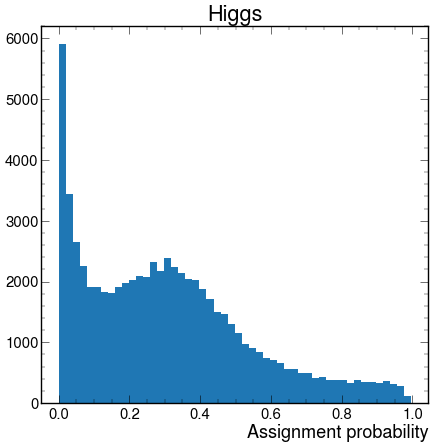

In [11]:
plt.hist(h_assign, bins=50)
plt.title("Higgs")
plt.xlabel("Assignment probability")
plt.show()

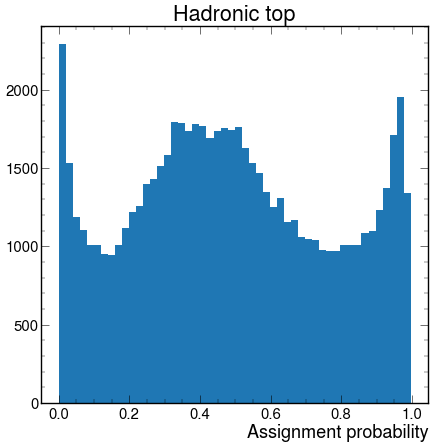

In [12]:
plt.hist(t1_assign, bins=50)
plt.title("Hadronic top")
plt.xlabel("Assignment probability")
plt.show()

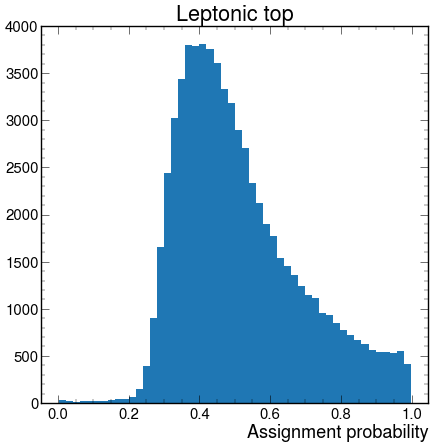

In [13]:
plt.hist(t2_assign, bins=50)
plt.title("Leptonic top")
plt.xlabel("Assignment probability")
plt.show()

## Detection probabilities

In [16]:
h_detect = df["TARGETS/h/detection_probability"]
t1_detect = df["TARGETS/t1/detection_probability"]
t2_detect = df["TARGETS/t2/detection_probability"]

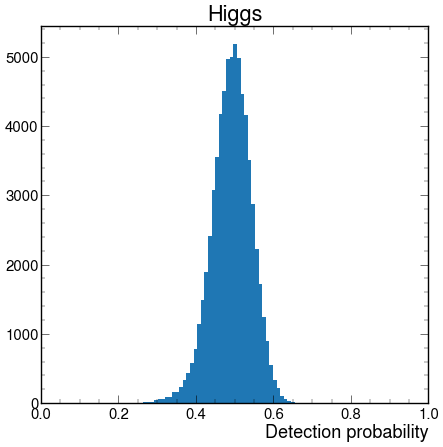

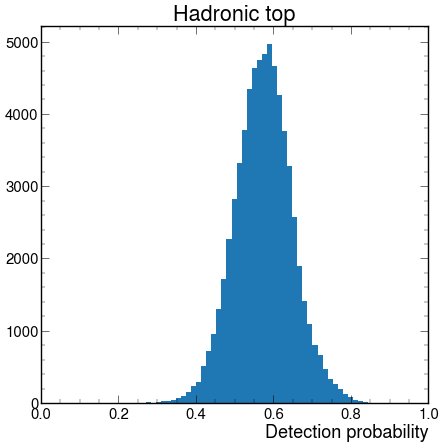

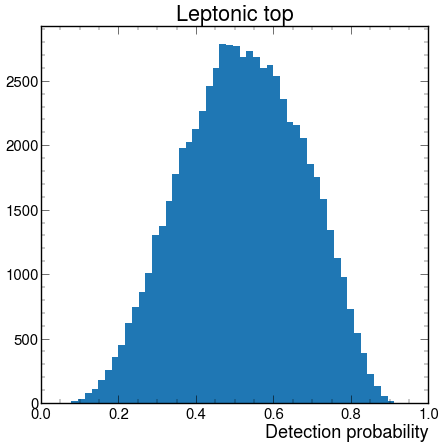

In [18]:
plt.hist(h_detect, bins=50)
plt.title("Higgs")
plt.xlabel("Detection probability")
plt.xlim(0,1)
plt.show()

plt.hist(t1_detect, bins=50)
plt.title("Hadronic top")
plt.xlabel("Detection probability")
plt.xlim(0,1)
plt.show()

plt.hist(t2_detect, bins=50)
plt.title("Leptonic top")
plt.xlabel("Detection probability")
plt.xlim(0,1)
plt.show()

## Leptonic top invariant mass

Reconstruct leptonic top with leptonic information

In [4]:
jets = jets[jets.matched == True]
higgs = jets[jets.prov == 1]
mask_match = ak.num(higgs) == 2

w_or_t_jets = jets[(jets.prov == 5)|(jets.prov == 2)]
mask_match = mask_match & (ak.num(w_or_t_jets) == 3)

lep_top = jets[jets.prov == 3]
mask_match = mask_match & (ak.num(lep_top) == 1)

jets = jets[mask_match]
lepton_reco = lepton_reco[mask_match]
met = met[mask_match]

In [4]:
# Leptonic top jets
t2_b_pred = ak.Array(df["TARGETS"]["t2"]["b"][()])
t2_b_pred = ak.unflatten(t2_b_pred, ak.ones_like(t2_b_pred))

t2_b_true = ak.Array(df_input["TARGETS"]["t2"]["b"][()])
t2_b_true = ak.unflatten(t2_b_true, ak.ones_like(t2_b_true))

leptop_index_pred = t2_b_pred
leptop_index_true = t2_b_true

leptop_jet_pred = jets[leptop_index_pred]
leptop_jet_true = jets[leptop_index_true]

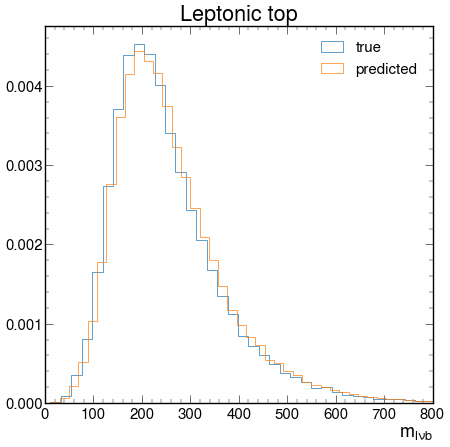

In [46]:
plt.hist((lepton_reco[:] + met[:] + leptop_jet_true[:,0]).m, bins=100,
         density=True, histtype="step", label="true")
plt.hist((lepton_reco[:] + met[:] + leptop_jet_pred[:,0]).m, bins=100,
         density=True, histtype="step", label="predicted")
plt.xlim(0,800)
plt.xlabel(r"$m_{l\nu b}$")
plt.title("Leptonic top")
plt.legend()
plt.show()

## 2D efficiency (H and t1)

Efficiency plot in 2D with Higgs pt and t1 pt. When t1 has low pt, is H efficiency high etc...

In [7]:
def get_leptop_arrays(n, njets, mode="partial"):

    # Leptonic top jets
    t2_b_pred = ak.Array(df["TARGETS"]["t2"]["b"][()])
    t2_b_pred = ak.unflatten(t2_b_pred, ak.ones_like(t2_b_pred))

    t2_b_true = ak.Array(df_input["TARGETS"]["t2"]["b"][()])
    t2_b_true = ak.unflatten(t2_b_true, ak.ones_like(t2_b_true))
    
    leptop_index_pred = t2_b_pred
    leptop_index_true = t2_b_true
    
    if mode == "partial":
        leptop_index_pred = leptop_index_pred[ak.num(jets)==n]
        leptop_index_true = leptop_index_true[ak.num(jets)==n]

    leptop_jet_pred = njets[leptop_index_pred]
    leptop_jet_true = njets[leptop_index_true]

    mask = (leptop_jet_true == leptop_jet_pred)
    leptop_pred_correct = leptop_jet_pred[mask] # correctly predicted jets
    leptop_pred_wrong = leptop_jet_pred[~mask] # wrongly predicted jets

    leptop_pred_correct = leptop_pred_correct[ak.num(leptop_pred_correct)>0]
    leptop_pred_wrong = leptop_pred_wrong[ak.num(leptop_pred_wrong)>0]

    return leptop_pred_correct, leptop_pred_wrong

def get_higgs_arrays(n, njets, mode="partial"):
    
    H_b1_true = ak.Array(df_input["TARGETS"]["h"]["b1"][()])
    H_b2_true = ak.Array(df_input["TARGETS"]["h"]["b2"][()])

    H_b1_true = ak.unflatten(H_b1_true, ak.ones_like(H_b1_true))
    H_b2_true = ak.unflatten(H_b2_true, ak.ones_like(H_b2_true))

    H_b1_pred = ak.Array(df["TARGETS"]["h"]["b1"][()])
    H_b2_pred = ak.Array(df["TARGETS"]["h"]["b2"][()])
    
    H_b1_pred = ak.unflatten(H_b1_pred, ak.ones_like(H_b1_pred))
    H_b2_pred = ak.unflatten(H_b2_pred, ak.ones_like(H_b2_pred))
 
    higgs_index_true = ak.concatenate((H_b1_true, H_b2_true), axis=1)
    higgs_index_pred = ak.concatenate((H_b1_pred, H_b2_pred), axis=1)
    
    if mode == "partial":
        higgs_index_true = higgs_index_true[ak.num(jets)==n]
        higgs_index_pred = higgs_index_pred[ak.num(jets)==n]

    higgs_jet_true = njets[higgs_index_true]
    higgs_jet_pred = njets[higgs_index_pred]
        
    mask = (higgs_jet_true == higgs_jet_pred)
    higgs_pred_correct = higgs_jet_pred[mask] # correctly predicted jets
    higgs_pred_wrong = higgs_jet_pred[~mask] # wrongly predicted jets

    higgs_pred_correct = higgs_pred_correct[ak.num(higgs_pred_correct)==2]
    higgs_pred_wrong = higgs_pred_wrong[ak.num(higgs_pred_wrong)>0]

    return higgs_pred_correct, higgs_pred_wrong

def get_hadtop_arrays(n, njets, mode="partial"):
    
    t1_q1_true = ak.Array(df_input["TARGETS"]["t1"]["q1"][()])
    t1_q2_true = ak.Array(df_input["TARGETS"]["t1"]["q2"][()])
    t1_b_true = ak.Array(df_input["TARGETS"]["t1"]["b"][()])

    t1_q1_true = ak.unflatten(t1_q1_true, ak.ones_like(t1_q1_true))
    t1_q2_true = ak.unflatten(t1_q2_true, ak.ones_like(t1_q2_true))
    t1_b_true = ak.unflatten(t1_b_true, ak.ones_like(t1_b_true))
    
    t1_q1_pred = ak.Array(df["TARGETS"]["t1"]["q1"][()])
    t1_q2_pred = ak.Array(df["TARGETS"]["t1"]["q2"][()])
    t1_b_pred = ak.Array(df["TARGETS"]["t1"]["b"][()])
    
    t1_q1_pred = ak.unflatten(t1_q1_pred, ak.ones_like(t1_q1_pred))
    t1_q2_pred = ak.unflatten(t1_q2_pred, ak.ones_like(t1_q2_pred))
    t1_b_pred = ak.unflatten(t1_b_pred, ak.ones_like(t1_b_pred))
 
    hadtop_index_true = ak.concatenate((t1_q1_true, t1_q2_true, t1_b_true), axis=1)
    hadtop_index_pred = ak.concatenate((t1_q1_pred, t1_q2_pred, t1_b_pred), axis=1)
    
    if mode == "partial":
        hadtop_index_true = hadtop_index_true[ak.num(jets)==n]
        hadtop_index_pred = hadtop_index_pred[ak.num(jets)==n]

    hadtop_jet_true = njets[hadtop_index_true]
    hadtop_jet_pred = njets[hadtop_index_pred]
        
    mask = (hadtop_jet_true == hadtop_jet_pred)
    hadtop_pred_correct = hadtop_jet_pred[mask] # correctly predicted jets
    hadtop_pred_wrong = hadtop_jet_pred[~mask] # wrongly predicted jets

    hadtop_pred_correct = hadtop_pred_correct[ak.num(hadtop_pred_correct)==3]
    hadtop_pred_wrong = hadtop_pred_wrong[ak.num(hadtop_pred_wrong)>0]

    return hadtop_pred_correct, hadtop_pred_wrong

def calculate_efficiency(particle, n, njets, mode="partial"):
    if particle == "h":
        pred_correct, pred_wrong = get_higgs_arrays(n, njets, mode)
    if particle == "t1":
        pred_correct, pred_wrong = get_hadtop_arrays(n, njets, mode)
    if particle == "t2":
        pred_correct, pred_wrong = get_leptop_arrays(n, njets, mode)
    print(f"\nNumber of correctly predicted within {n} jets is {len(pred_correct)}")
    print(f"Number of wrongly predicted within {n} jets is {len(pred_wrong)}")
    print(f"Total within {n} jets is {len(njets)}")
    
    purity = len(pred_correct)/len(njets)
    print(f"{n}-jet efficiency is {purity:.3f}")
    
    return pred_correct, pred_wrong

In [8]:
def find_bin(value, bins):
    """ bins is a list of tuples, like [(0,20), (20, 40), (40, 60)],
        binning returns the smallest index i of bins so that
        bin[i][0] <= value < bin[i][1]
    """
    for i in range(0, len(bins)):
        if bins[i][0] <= value < bins[i][1]:
            return i
    return -1

def create_bins(lower_bound, width, quantity):
    """ create_bins returns an equal-width (distance) partitioning. 
        It returns an ascending list of tuples, representing the intervals.
        A tuple bins[i], i.e. (bins[i][0], bins[i][1])  with i > 0 
        and i < quantity, satisfies the following conditions:
            (1) bins[i][0] + width == bins[i][1]
            (2) bins[i-1][0] + width == bins[i][0] and
                bins[i-1][1] + width == bins[i][1]
    """
    bins = []
    for low in range(lower_bound, lower_bound + quantity*width + 1, width):
        bins.append((low, low+width))
    return bins

In [9]:
def pt_efficiency(true_pt, pred_pt, nbins, binwidth):
    
    # Bin the array of predicted pts
    data = pd.DataFrame({"pt": pred_pt})

    bins = create_bins(lower_bound=0, width=binwidth, quantity=nbins)
    bin_means = []
    for i in range(len(bins)):
        bin_means.append((bins[i][0] + bins[i][1])/2)

    bins = pd.IntervalIndex.from_tuples(bins)
    data['pt_bin'] = pd.cut(data['pt'], bins=bins)
    
    # Find all counts (correctly and wrongly predicted -- denominator of efficiency)
    a = data['pt_bin'].value_counts(sort=False)
    a.index = a.index.astype(str)
    a = a.to_dict()
    all_counts = np.array(list(a.values()))
    
    # Construct correctly predicted and wrongly predicted jet pts
    mask = (true_pt == pred_pt)

    # Find counts of correctly predicted events
    data['correct'] = mask
    data = data[data['correct']==True]
    c = data['pt_bin'].value_counts(sort=False)
    c.index = c.index.astype(str)
    c = c.to_dict()
    correct_counts = np.array(list(c.values()))

    # Find the efficiency for each interval
    bin_efficiency = np.zeros(len(correct_counts))

    for i in range(len(all_counts)):
        if all_counts[i] > 0: # disregard empty bins and assign 0 efficiency to them
            bin_efficiency[i] = correct_counts[i]/all_counts[i]
        else:
            bin_efficiency[i] = 0
            
    return bin_means, bin_efficiency

In [5]:
H_b1_true = ak.Array(df_input["TARGETS"]["h"]["b1"][()])
H_b2_true = ak.Array(df_input["TARGETS"]["h"]["b2"][()])

H_b1_true = ak.unflatten(H_b1_true, ak.ones_like(H_b1_true))
H_b2_true = ak.unflatten(H_b2_true, ak.ones_like(H_b2_true))

H_b1_pred = ak.Array(df["TARGETS"]["h"]["b1"][()])
H_b2_pred = ak.Array(df["TARGETS"]["h"]["b2"][()])

H_b1_pred = ak.unflatten(H_b1_pred, ak.ones_like(H_b1_pred))
H_b2_pred = ak.unflatten(H_b2_pred, ak.ones_like(H_b2_pred))

higgs_index_true = ak.concatenate((H_b1_true, H_b2_true), axis=1)
higgs_index_pred = ak.concatenate((H_b1_pred, H_b2_pred), axis=1)

higgs_jet_true = jets[higgs_index_true]
higgs_jet_pred = jets[higgs_index_pred]

higgs_true_pt = (higgs_jet_true[:,0] + higgs_jet_true[:,1]).pt
higgs_pred_pt = (higgs_jet_pred[:,0] + higgs_jet_pred[:,1]).pt

t1_q1_true = ak.Array(df_input["TARGETS"]["t1"]["q1"][()])
t1_q2_true = ak.Array(df_input["TARGETS"]["t1"]["q2"][()])
t1_b_true = ak.Array(df_input["TARGETS"]["t1"]["b"][()])

t1_q1_true = ak.unflatten(t1_q1_true, ak.ones_like(t1_q1_true))
t1_q2_true = ak.unflatten(t1_q2_true, ak.ones_like(t1_q2_true))
t1_b_true = ak.unflatten(t1_b_true, ak.ones_like(t1_b_true))

t1_q1_pred = ak.Array(df["TARGETS"]["t1"]["q1"][()])
t1_q2_pred = ak.Array(df["TARGETS"]["t1"]["q2"][()])
t1_b_pred = ak.Array(df["TARGETS"]["t1"]["b"][()])

t1_q1_pred = ak.unflatten(t1_q1_pred, ak.ones_like(t1_q1_pred))
t1_q2_pred = ak.unflatten(t1_q2_pred, ak.ones_like(t1_q2_pred))
t1_b_pred = ak.unflatten(t1_b_pred, ak.ones_like(t1_b_pred))

hadtop_index_true = ak.concatenate((t1_q1_true, t1_q2_true, t1_b_true), axis=1)
hadtop_index_pred = ak.concatenate((t1_q1_pred, t1_q2_pred, t1_b_pred), axis=1)

hadtop_jet_true = jets[hadtop_index_true]
hadtop_jet_pred = jets[hadtop_index_pred]

hadtop_true_pt = (hadtop_jet_true[:,0] + hadtop_jet_true[:,1] + hadtop_jet_true[:,2]).pt
hadtop_pred_pt = (hadtop_jet_pred[:,0] + hadtop_jet_pred[:,1] + hadtop_jet_pred[:,2]).pt

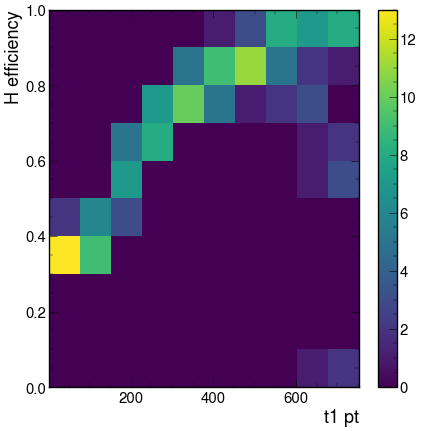

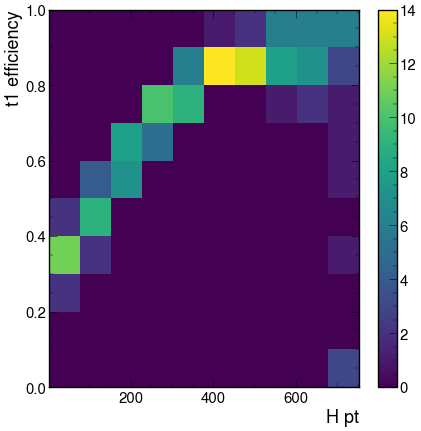

In [88]:
h_means, h_efficiency = pt_efficiency(higgs_true_pt, higgs_pred_pt,
                                      nbins=150, binwidth=5)
t1_means, t1_efficiency = pt_efficiency(hadtop_true_pt, hadtop_pred_pt,
                                        nbins=150, binwidth=5)

plt.hist2d(t1_means, h_efficiency)
plt.xlabel("t1 pt")
plt.ylabel("H efficiency")
plt.colorbar()
plt.show()

plt.hist2d(h_means, t1_efficiency)
plt.xlabel("H pt")
plt.ylabel("t1 efficiency")
plt.colorbar()
plt.show()

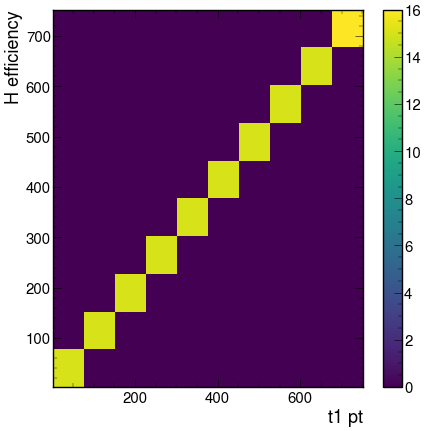

In [10]:
h_means, h_efficiency = pt_efficiency(higgs_true_pt, higgs_pred_pt,
                                      nbins=150, binwidth=5)
t1_means, t1_efficiency = pt_efficiency(hadtop_true_pt, hadtop_pred_pt,
                                        nbins=150, binwidth=5)

plt.hist2d(t1_means, h_means)
plt.xlabel("t1 pt")
plt.ylabel("H efficiency")
plt.colorbar()
plt.show()


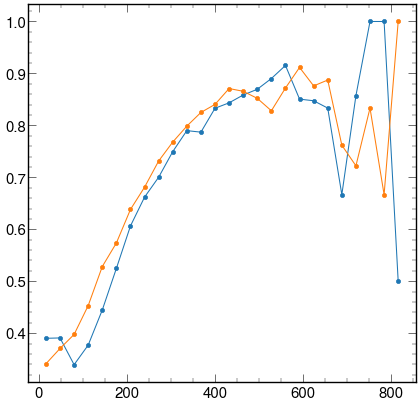

In [72]:
plt.plot(h_means, h_efficiency, marker='o')
plt.plot(t1_means, t1_efficiency, marker='o')

## Difference in pt 

How far apart in pt are the correct jet and the predicted jet (for each particle). In these plots I exclude the correct predictions.

Average pt difference: 64.149
Median pt difference: 47.997
Maximum pt difference: 772.323
Minimum pt difference: 0.002


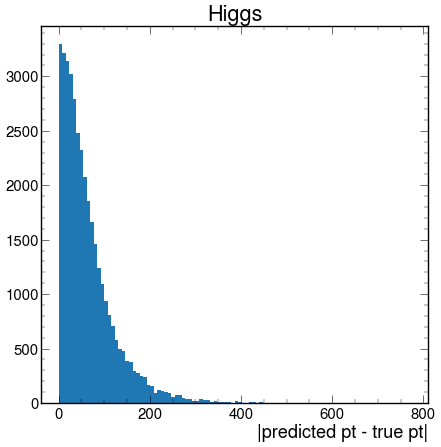

In [97]:
difference = abs(higgs_true_pt - higgs_pred_pt)
# Exclude correct predictions, i.e. zero differences
difference = difference[difference > 0.]
print(f"Average pt difference: {np.mean(difference):.3f}")
print(f"Median pt difference: {np.median(difference):.3f}")
print(f"Maximum pt difference: {np.max(difference):.3f}")
print(f"Minimum pt difference: {np.min(difference):.3f}")
plt.hist(difference, bins=100)
plt.xlabel("|predicted pt - true pt|")
plt.title("Higgs")
plt.show()

Average pt difference: 21.408
Median pt difference: 18.505
Maximum pt difference: 675.493
Minimum pt difference: -772.323


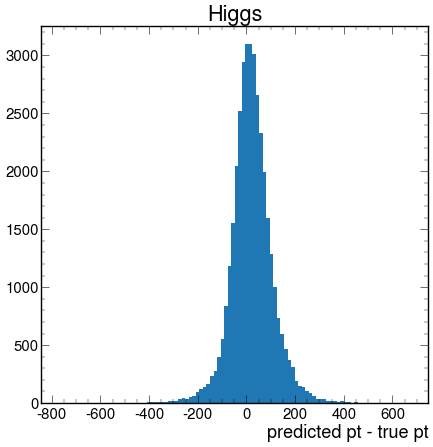

In [109]:
difference = higgs_true_pt - higgs_pred_pt
# Exclude correct predictions, i.e. zero differences
difference = difference[difference != 0.]
print(f"Average pt difference: {np.mean(difference):.3f}")
print(f"Median pt difference: {np.median(difference):.3f}")
print(f"Maximum pt difference: {np.max(difference):.3f}")
print(f"Minimum pt difference: {np.min(difference):.3f}")
plt.hist(difference, bins=100)
plt.xlabel("predicted pt - true pt")
plt.title("Higgs")
plt.show()

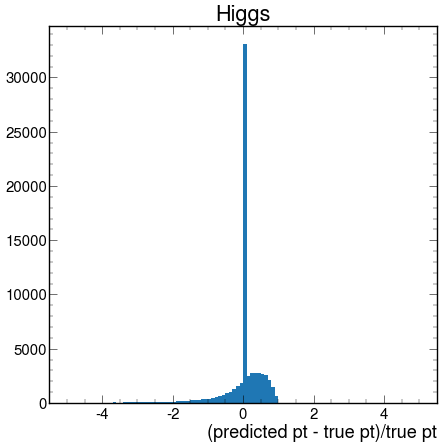

rms: 64.705
Average pt difference: 21.408
Median pt difference: 18.505
Maximum pt difference: 675.493
Minimum pt difference: -772.323


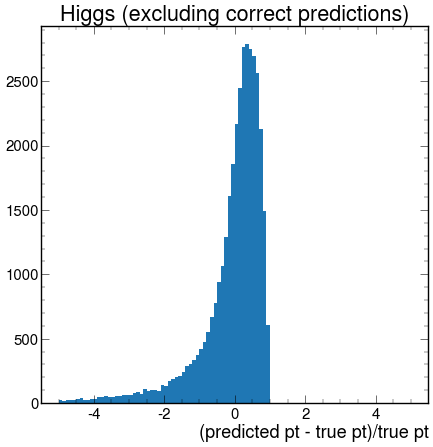

In [30]:
# rms of delta pt over pt
difference = higgs_true_pt - higgs_pred_pt
# Exclude correct predictions, i.e. zero differences
#true_pt = higgs_true_pt[difference != 0.]
#difference = difference[difference != 0.]

rms_difference = np.sqrt(np.sum(difference**2)/len(difference))

plt.hist(difference/higgs_true_pt, bins=100, range=(-5,5))
plt.xlabel("(predicted pt - true pt)/true pt")
plt.title("Higgs")
plt.show()

print(f"rms: {rms_difference:.3f}")
true_pt = higgs_true_pt[difference != 0.]
difference = difference[difference != 0.]

print(f"Average pt difference: {np.mean(difference):.3f}")
print(f"Median pt difference: {np.median(difference):.3f}")
print(f"Maximum pt difference: {np.max(difference):.3f}")
print(f"Minimum pt difference: {np.min(difference):.3f}")

plt.hist(difference/true_pt, bins=100, range=(-5,5))
plt.xlabel("(predicted pt - true pt)/true pt")
plt.title("Higgs (excluding correct predictions)")
plt.show()

Average pt difference: 61.858
Median pt difference: 45.092
Maximum pt difference: 676.104
Minimum pt difference: 9.5367431640625e-07


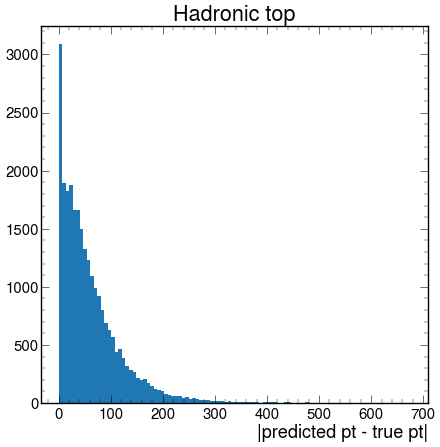

In [103]:
difference = abs(hadtop_true_pt - hadtop_pred_pt)
# Exclude correct predictions, i.e. zero differences
difference = difference[difference > 0.]

print(f"Average pt difference: {np.mean(difference):.3f}")
print(f"Median pt difference: {np.median(difference):.3f}")
print(f"Maximum pt difference: {np.max(difference):.3f}")
print(f"Minimum pt difference: {np.min(difference)}")
plt.hist(difference, bins=100)
plt.xlabel("|predicted pt - true pt|")
plt.title("Hadronic top")
plt.show()

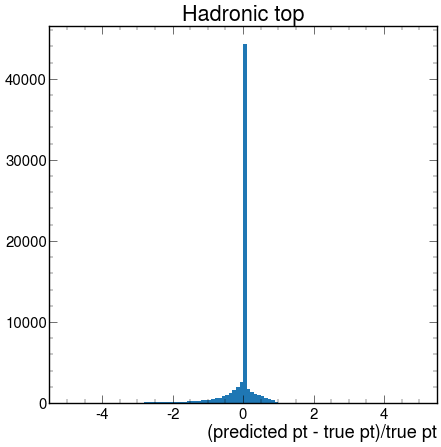

rms: 54.151
Average pt difference: -20.459
Median pt difference: -15.451
Maximum pt difference: 625.641
Minimum pt difference: -676.1036987304688


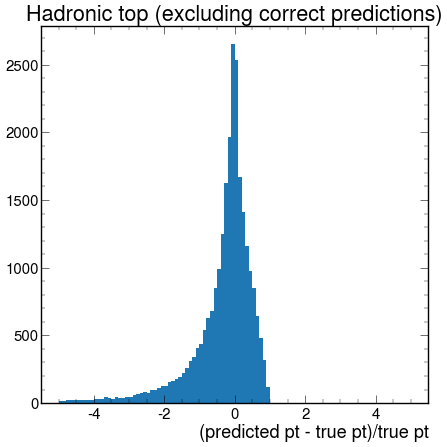

In [31]:
difference = hadtop_true_pt - hadtop_pred_pt
# Exclude correct predictions, i.e. zero differences
#difference = difference[difference != 0.]

rms_difference = np.sqrt(np.sum(difference**2)/len(difference))

plt.hist(difference/hadtop_true_pt, bins=100, range=(-5,5))
plt.xlabel("(predicted pt - true pt)/true pt")
plt.title("Hadronic top")
plt.show()

print(f"rms: {rms_difference:.3f}")
true_pt = hadtop_true_pt[difference != 0.]
difference = difference[difference != 0.]

print(f"Average pt difference: {np.mean(difference):.3f}")
print(f"Median pt difference: {np.median(difference):.3f}")
print(f"Maximum pt difference: {np.max(difference):.3f}")
print(f"Minimum pt difference: {np.min(difference)}")

plt.hist(difference/true_pt, bins=100, range=(-5,5))
plt.xlabel("(predicted pt - true pt)/true pt")
plt.title("Hadronic top (excluding correct predictions)")
plt.show()

In [28]:
# Leptonic top jets
t2_b_pred = ak.Array(df["TARGETS"]["t2"]["b"][()])
t2_b_pred = ak.unflatten(t2_b_pred, ak.ones_like(t2_b_pred))

t2_b_true = ak.Array(df_input["TARGETS"]["t2"]["b"][()])
t2_b_true = ak.unflatten(t2_b_true, ak.ones_like(t2_b_true))

leptop_index_pred = t2_b_pred
leptop_index_true = t2_b_true

leptop_jet_pred = jets[leptop_index_pred]
leptop_jet_true = jets[leptop_index_true]

leptop_pred_pt = leptop_jet_pred[:,0].pt
leptop_true_pt = leptop_jet_true[:,0].pt

Average pt difference: 45.625
Median pt difference: 31.750
Maximum pt difference: 782.156
Minimum pt difference: 0.016


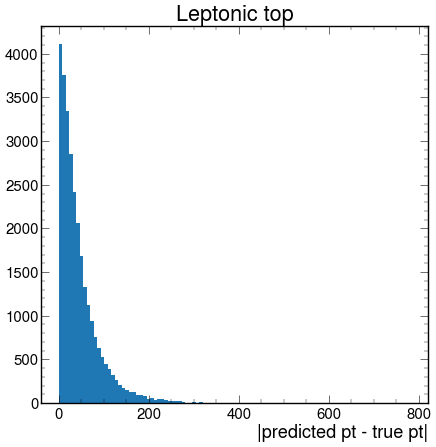

In [105]:
difference = abs(leptop_true_pt - leptop_pred_pt)
# Exclude correct predictions, i.e. zero differences
difference = difference[difference > 0.]

print(f"Average pt difference: {np.mean(difference):.3f}")
print(f"Median pt difference: {np.median(difference):.3f}")
print(f"Maximum pt difference: {np.max(difference):.3f}")
print(f"Minimum pt difference: {np.min(difference):.3f}")
plt.hist(difference, bins=100)
plt.xlabel("|predicted pt - true pt|")
plt.title("Leptonic top")
plt.show()

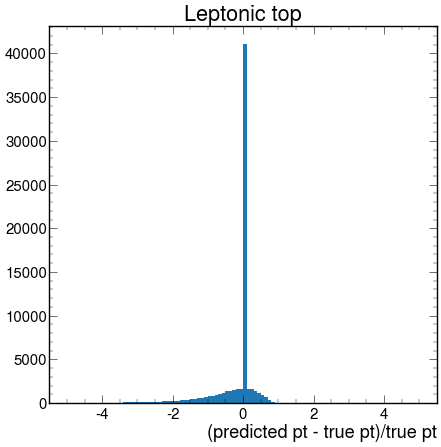

rms: 42.421
Average pt difference: -18.939
Median pt difference: -17.094
Maximum pt difference: 782.156
Minimum pt difference: -422.1875


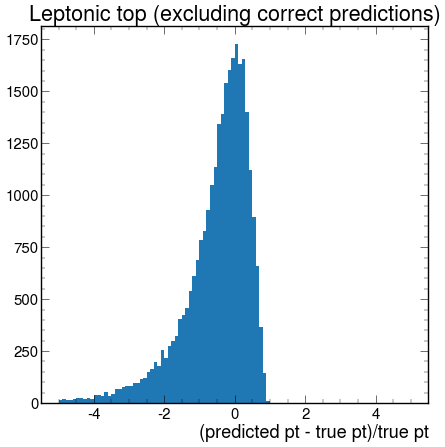

In [32]:
difference = leptop_true_pt - leptop_pred_pt
# Exclude correct predictions, i.e. zero differences
#difference = difference[difference != 0.]

rms_difference = np.sqrt(np.sum(difference**2)/len(difference))

plt.hist(difference/leptop_true_pt, bins=100, range=(-5,5))
plt.xlabel("(predicted pt - true pt)/true pt")
plt.title("Leptonic top")
plt.show()

print(f"rms: {rms_difference:.3f}")

true_pt = leptop_true_pt[difference != 0.]
difference = difference[difference != 0.]

print(f"Average pt difference: {np.mean(difference):.3f}")
print(f"Median pt difference: {np.median(difference):.3f}")
print(f"Maximum pt difference: {np.max(difference):.3f}")
print(f"Minimum pt difference: {np.min(difference)}")

plt.hist(difference/true_pt, bins=100, range=(-5,5))
plt.xlabel("(predicted pt - true pt)/true pt")
plt.title("Leptonic top (excluding correct predictions)")
plt.show()

## Difference in $\Delta$R

Average delta R: 1.886
Median delta R: 1.845
Maximum delta R: 4.759
Minimum delta R: 0.392


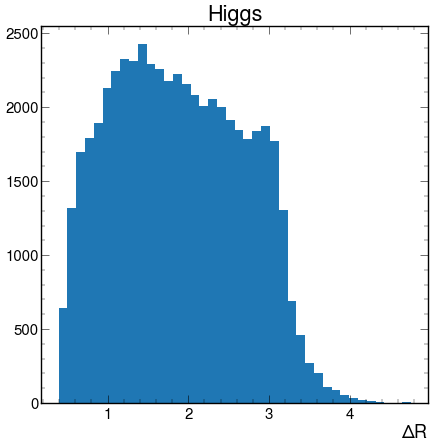

In [39]:
deltar = ak.flatten(higgs_jet_true.deltaR(higgs_jet_pred))
# delete correctly predicted
deltar = deltar[deltar != 0.]

print(f"Average delta R: {np.mean(deltar):.3f}")
print(f"Median delta R: {np.median(deltar):.3f}")
print(f"Maximum delta R: {np.max(deltar):.3f}")
print(f"Minimum delta R: {np.min(deltar):.3f}")

plt.hist(deltar, bins=40)
plt.xlabel(r"$\Delta R$")
plt.title("Higgs")
plt.show()

Average delta R: 1.822
Median delta R: 1.753
Maximum delta R: 5.511
Minimum delta R: 0.391


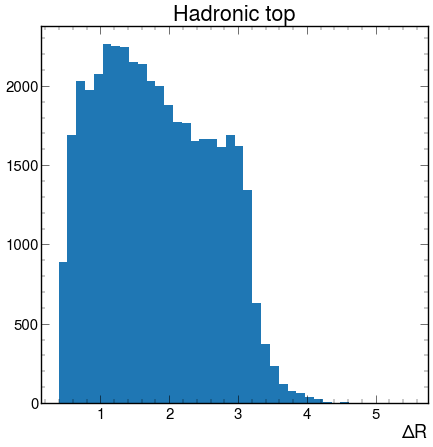

In [38]:
deltar = ak.flatten(hadtop_jet_true.deltaR(hadtop_jet_pred))
# delete correctly predicted
deltar = deltar[deltar != 0.]

print(f"Average delta R: {np.mean(deltar):.3f}")
print(f"Median delta R: {np.median(deltar):.3f}")
print(f"Maximum delta R: {np.max(deltar):.3f}")
print(f"Minimum delta R: {np.min(deltar):.3f}")

plt.hist(deltar, bins=40)
plt.xlabel(r"$\Delta R$")
plt.title("Hadronic top")
plt.show()

Average delta R: 1.999
Median delta R: 2.011
Maximum delta R: 5.511
Minimum delta R: 0.401


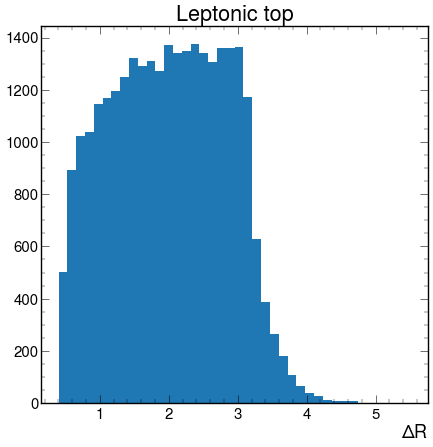

In [37]:
deltar = ak.flatten(leptop_jet_true.deltaR(leptop_jet_pred))
# delete correctly predicted
deltar = deltar[deltar != 0.]

print(f"Average delta R: {np.mean(deltar):.3f}")
print(f"Median delta R: {np.median(deltar):.3f}")
print(f"Maximum delta R: {np.max(deltar):.3f}")
print(f"Minimum delta R: {np.min(deltar):.3f}")

plt.hist(deltar, bins=40)
plt.xlabel(r"$\Delta R$")
plt.title("Leptonic top")
plt.show()